In [1]:
from muler.igrins import IGRINSSpectrum
from muler.hpf import HPFSpectrum

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import os
import warnings

import astropy.units as u
# from astropy.io import ascii
# from astropy.io import fits
# from astropy.table import Table, Column, join
# from astropy.wcs import WCS
from astropy.modeling import models, fitting

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum, fit_lines, find_lines_threshold
from specutils.analysis import equivalent_width
from specutils.manipulation import noise_region_uncertainty

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False

In [2]:
# path = 'A:/Documents/Grad_School/Research/igrins_reduced/20161101/'
# filename = 'SDCK_20161101_0062.spec_a0v.fits'
# spec = IGRINSSpectrum(file=path+filename)

# Reduced data in txt files
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
# File path for figures to live in
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"merged_standards/m*.txt")

# NIR Lines in micron
nir_dict = {
    "Fe-2.084": 2.084,
    "Si-2.092"	:	2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573"	:	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297
}
    # "CO(2-0)-2.29353" :	2.29353,
    # "CO(2-0)-2.32265"	:	2.32265,
    # "CO(2-0)-2.34327" :	2.34327,
    # "CO(2-0)-2.34531" :	2.34531,
    # "CO(2-0)-2.3495" 	:	2.3495,
    # "CO(2-0)-2.35167"	:	2.35167,
    # "CO(2-0)-2.35246" :	2.35246,
    # "CO(2-0)-2.38295" :	2.38295,
    # }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = list(nir_dict.values())

# Just a list of the elemental shorthand symbols
labels = [string.split('-')[0] for string in lines_str]

In [3]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

In [4]:
# Pandas Column IDs
igrins_cols = ['Wavelength', 'Flux', 'SNR','zero']

# Anon 1
anon1_df = pd.read_csv(merged_standard_files[0], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is an object for some reason, change to float
anon1_df['SNR'] = anon1_df['SNR'].astype(float)

# No negative flux and require SNR > 5
#  & (anon1_df['SNR'] < 10000)
anon1_df = anon1_df[(anon1_df['Wavelength'] > 2.) & (anon1_df['Flux'] > 0.4e6) & (anon1_df['SNR'] > 100) & (anon1_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
anon1_wavlen = anon1_df['Wavelength']
anon1_flux = anon1_df['Flux']

# Ti-2.224

In [5]:
# Central anon1_wavlenlength (micron)
wave_center = 2.224
spec_res = 0.00001

# Define the edges of the feature along spectral axis (NOT FLUX)
wave_lim1 = wave_center - (40*spec_res)
wave_lim2 = wave_center + (35*spec_res)

# Find the indices for the min and max wavelengths of the spectral feature 
wavemin = (np.abs(anon1_wavlen-wave_lim1)).argmin()
wavemax = (np.abs(anon1_wavlen-wave_lim2)).argmin()

# # Choose spectral regions on either side of spectral feature to define a continuum
contlo_1 = wave_lim1-(125*spec_res)
contlo_2 = wave_lim1

conthi_1 = wave_lim2
conthi_2 = wave_lim2+(125*spec_res)

# # Find the indices for the continuum regions on either side of the spectral feature
contlo_min = np.abs(anon1_wavlen - contlo_1).argmin()
contlo_max = np.abs(anon1_wavlen - contlo_2).argmin()

conthi_min = np.abs(anon1_wavlen - conthi_1).argmin()
conthi_max = np.abs(anon1_wavlen - conthi_2).argmin()

In [6]:
np.abs(anon1_wavlen).argmin()

0

In [7]:
wavemin, wavemax

(15439, 15488)

In [8]:
# anon1_wavlen[wavemin:wavemax]

In [9]:
contlo_1, contlo_2

(2.22235, 2.2236000000000002)

In [10]:
contlo_min,contlo_max

(15357, 15439)

In [11]:
# anon1_wavlen[contlo_min],anon1_wavlen[contlo_max]

In [12]:
contlo_min

15357

In [13]:
# anon1_wavlen[contlo_min],anon1_wavlen[contlo_max]

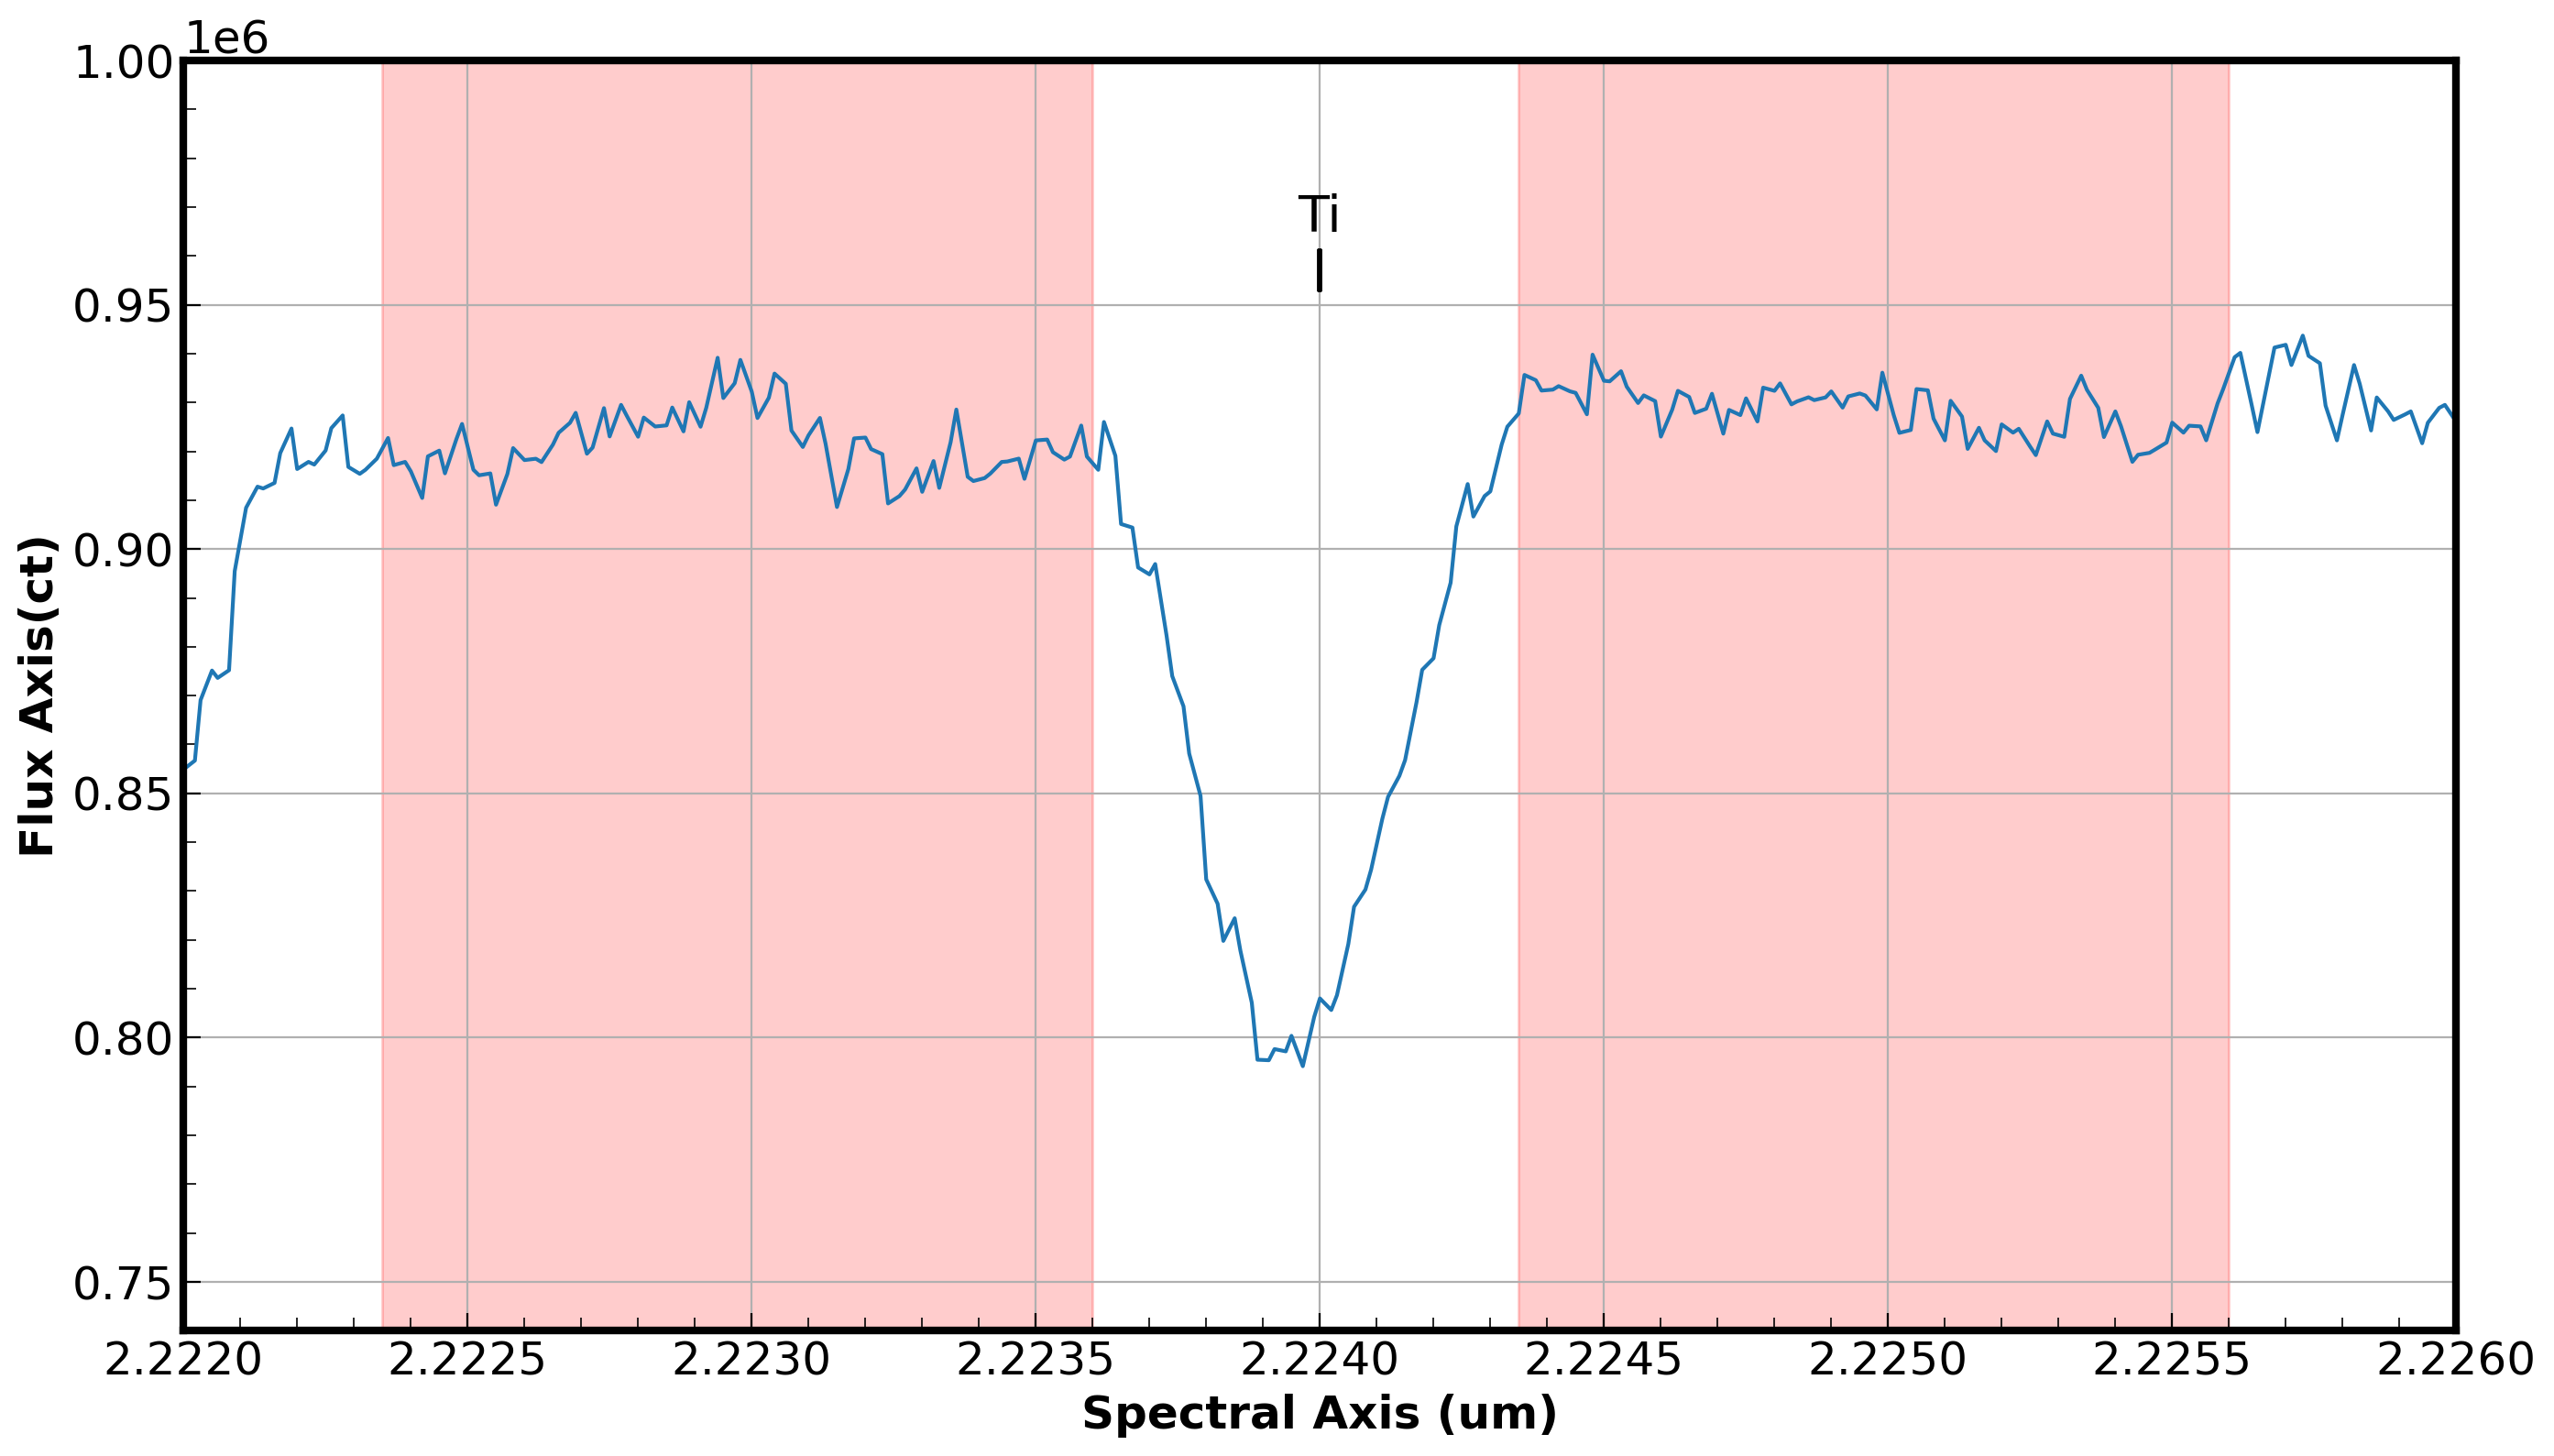

In [14]:
# Make 1D Spectrum Object
anon1_spec = Spectrum1D(spectral_axis=anon1_wavlen.values*u.um,flux=anon1_flux.values*u.ct)
fig,ax = plt.subplots(figsize=(16,9))

plt.plot(anon1_spec.spectral_axis, anon1_spec.flux)
# plt.plot(anon1_spec.spectral_axis, anon1_cont)

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        plt.axvline(lines_wav[ii],0.82,0.85,color='black')
    # ax.text(lines_wav[ii],text_y,labels,ha='center')


plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2)
plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)

text_y = 0.965e6
# ax.text(nir_dict['Ti-2.2218'],text_y,'Ti',ha='center')
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Fe-2.226'],text_y,'Fe',ha='center')
# ax.text(nir_dict['Ti-2.228'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Ti-2.232'],text_y,'Ti',ha='center')

# Set fig axis limits
plt.xlim(2.222,2.226)
plt.ylim(0.74e6,1e6)

# Enable minor tick marks
ax.minorticks_on()

plt.xlabel('Spectral Axis ({})'.format(anon1_spec.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(anon1_spec.flux.unit)) 
ax.grid()
plt.show()

In [15]:
anon1_wavlen[contlo_min:contlo_max]

26264    2.22236
26265    2.22237
26266    2.22239
26267    2.22240
26268    2.22242
          ...   
26341    2.22353
26342    2.22355
26343    2.22356
26344    2.22358
26345    2.22359
Name: Wavelength, Length: 82, dtype: float64

In [16]:
# estimate continuum using mean of points in selected range
# wavelengths
contlo_wave = anon1_wavlen[contlo_min:contlo_max]
conthi_wave = anon1_wavlen[conthi_min:conthi_max]
# fluxes
contlo_flux = anon1_flux[contlo_min:contlo_max]
conthi_flux = anon1_flux[conthi_min:conthi_max]

contwave_array = np.concatenate((contlo_wave, conthi_wave))
contflux_array = np.concatenate((contlo_flux, conthi_flux))

mean_cont = np.sum(contflux_array)/len(contflux_array)

# estimate continuum using 1d polyfit to points in selected range
cont_fit = np.polyfit(contwave_array, contflux_array, 2)
fitval = np.poly1d(cont_fit)
continuum = fitval(anon1_wavlen)

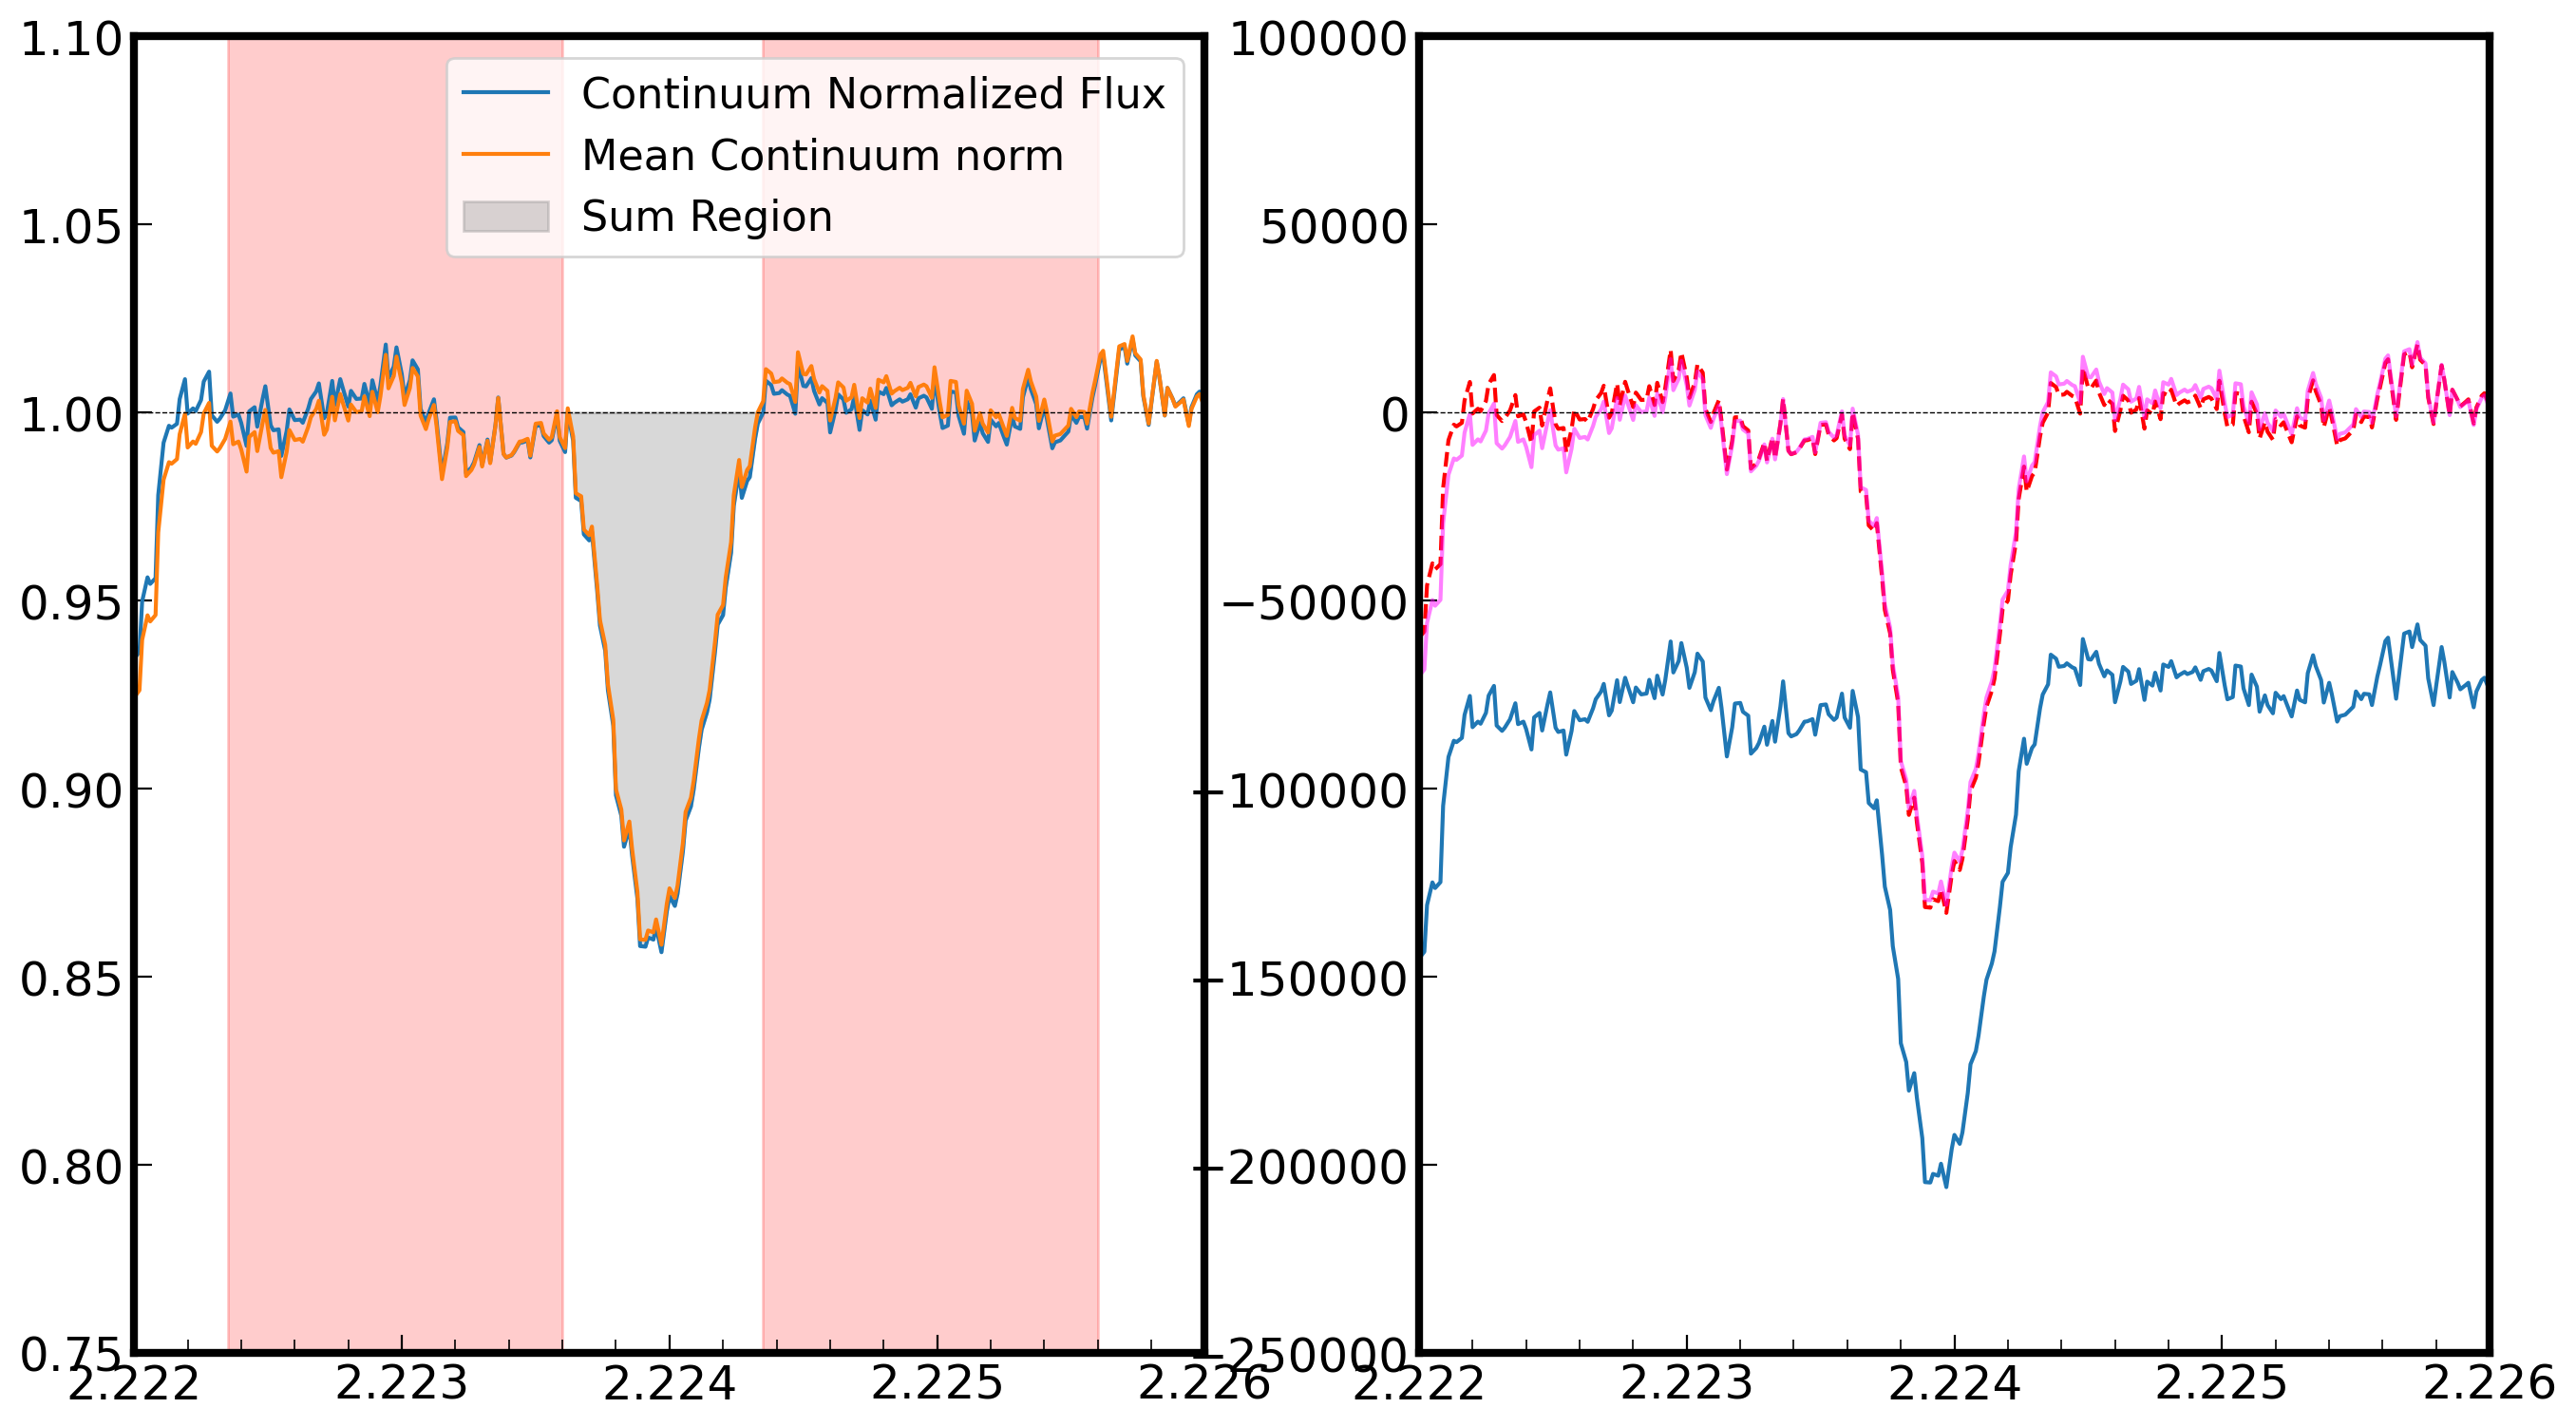

In [17]:
#examine the continuum-modified spectra

cont_sub = anon1_flux-continuum # the polyfit continuum-subtracted flux
cont_norm = anon1_flux/continuum # polyfit continuum normalized flux

meancont_sub = anon1_flux-mean_cont # the mean continuum-subtracted flux
meancont_norm = anon1_flux/mean_cont # mean continuum normalized flux


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,9))
plt.subplot(121)
# plt.plot(anon1_wavlen, anon1_flux,label='Original Flux')
# plt.plot(anon1_wavlen, continuum,label='Continuum')

plt.plot(anon1_wavlen, cont_norm,label='Continuum Normalized Flux')
plt.plot(anon1_wavlen, meancont_norm,label='Mean Continuum norm')

# plt.plot(anon1_wavlen, cont_sub, color='red', linestyle='dashed',label='Poly fit subtracted')
# plt.plot(anon1_wavlen, meancont_sub, color='magenta',label='Mean Continuum subtracted')

# ax1.set_yscale('log')

plt.xlim(2.222,2.226)
plt.ylim(.75,1.1)

# plt.axvspan(anon1_wavlen[contlo_min], anon1_wavlen[contlo_max], color='red', alpha=0.2)
# plt.axvspan(anon1_wavlen[conthi_min], anon1_wavlen[conthi_max], color='red', alpha=0.2)
plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2)
plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)
plt.axhline(y=1, color='black', linewidth=0.5, linestyle='dashed')
plt.fill_between(anon1_wavlen, y1=cont_norm,y2=1.0, where=(anon1_wavlen >= contlo_2) & (anon1_wavlen <= conthi_1), color='gray', alpha=0.3, label='Sum Region')

plt.legend()

plt.subplot(122)
plt.plot(anon1_wavlen, anon1_flux-1e6)
plt.plot(anon1_wavlen, cont_sub, color='red', linestyle='dashed')
plt.plot(anon1_wavlen, meancont_sub, color='magenta', alpha=0.5)


plt.xlim(2.222,2.226)
plt.ylim(-0.25e6,.1e6)

plt.axhline(y=0, color='black', linewidth=0.5, linestyle='dashed')

ax.minorticks_on()
plt.savefig(fig_path+'anon1_Ti_2_224.png')
plt.show()
#plt.scatter(4.18,4.75, color='magenta', marker='o', s=25)
#plt.scatter(4.18,4.5, color='red', marker='o', s=25)

#plt.text(4.181,4.7, s="= mean continuum", color='magenta', fontsize=14)
#plt.text(4.181,4.45, s="= fit continuum", color='red', fontsize=14)

In [18]:
# Fit a Gaussian to the absorption feature between wavemin and wavemax
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

In [19]:
# Find valid indices within the range of anon1_wavlen for fitting
valid_indices = np.where((anon1_wavlen >= anon1_wavlen[wavemin]) & (anon1_wavlen <= anon1_wavlen[wavemax]))

In [20]:
#Define the Gaussian function
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

# Define the Gaussian function
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y

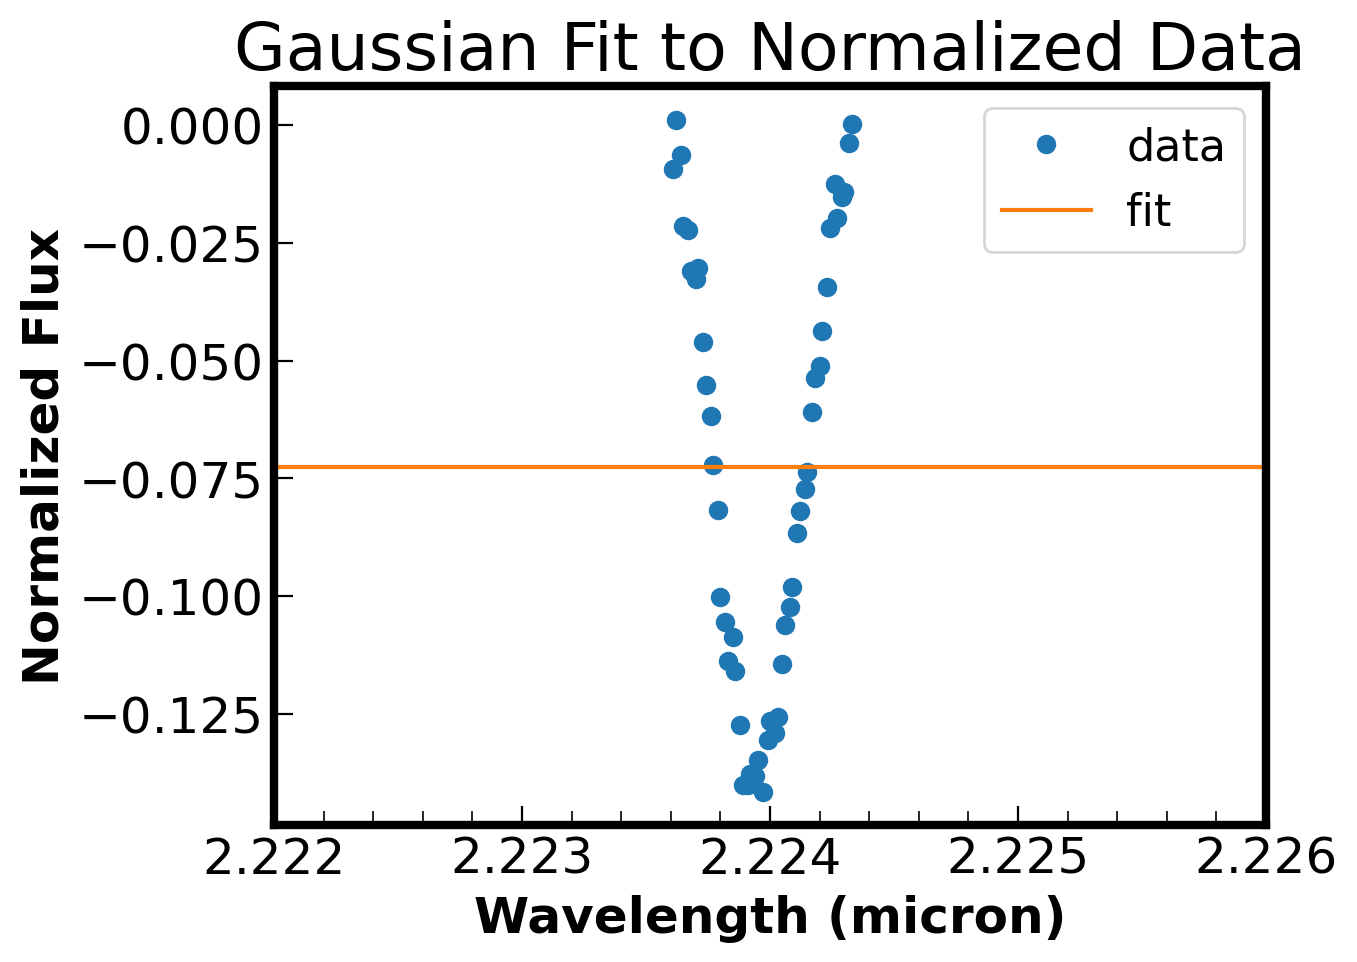

In [21]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def Gauss(x, A, B, C):
    return A * np.exp(-0.5 * ((x - B) / C) ** 2)

# Normalize the data before fitting
cont_norm = (anon1_flux - mean_cont) / mean_cont

# Fit the Gaussian function to the data in the range wavemin to wavemax
param, cov = curve_fit(Gauss, anon1_wavlen[wavemin:wavemax], cont_norm[wavemin:wavemax], p0=[1.0, anon1_wavlen[wavemin + wavemax // 2], 1.0])

fit_A, fit_B, fit_C = param

fit_y = Gauss(anon1_wavlen, fit_A, fit_B, fit_C)

# Plot the original data and the Gaussian fit
plt.plot(anon1_wavlen[wavemin:wavemax], cont_norm[wavemin:wavemax], 'o', label='data')
plt.plot(anon1_wavlen, fit_y, '-', label='fit')

plt.xlim(2.222,2.226)

plt.legend()
plt.xlabel('Wavelength (micron)')
plt.ylabel('Normalized Flux')
plt.title('Gaussian Fit to Normalized Data')
plt.show()

In [22]:
from scipy.optimize import curve_fit
param, cov = curve_fit(Gauss, anon1_wavlen[wavemin:wavemax], cont_norm[wavemin:wavemax])

fit_A = param[0]
fit_B = param[1]
  
fit_y = Gauss(anon1_wavlen, fit_A, fit_B)

plt.plot(anon1_wavlen[wavemin:wavemax], cont_norm[wavemin:wavemax],'o', label='data')
plt.plot(anon1_wavlen[wavemin:wavemax], fit_y[wavemin:wavemax], '-', label='fit')
plt.legend()
plt.show()

TypeError: Gauss() missing 1 required positional argument: 'C'

In [ ]:
x_fit = anon1_wavlen[wavemin:wavemax]
y_fit = anon1_flux[wavemin:wavemax]

In [ ]:
np.sum(anon1_flux[wavemin:wavemax])

42034073.0

In [ ]:
np.sum(continuum[wavemin:wavemax])

45423613.0801754

# Equivalent Width !?

\begin{equation} W_\lambda = \int{\frac{F_c - F_s}{F_c}}d\lambda = \int (1- F_s/F_c) d\lambda \end{equation}

In [ ]:
np.sum((continuum[wavemin:wavemax]-anon1_flux[wavemin:wavemax])/continuum[wavemin:wavemax])

3.65630718380597

In [ ]:
np.trapz(1-(anon1_flux[wavemin:wavemax]/continuum[wavemin:wavemax]))

3.649605786983698

# Try to do some continuum fitting
Want to fit a local continuum to get equivalent widths

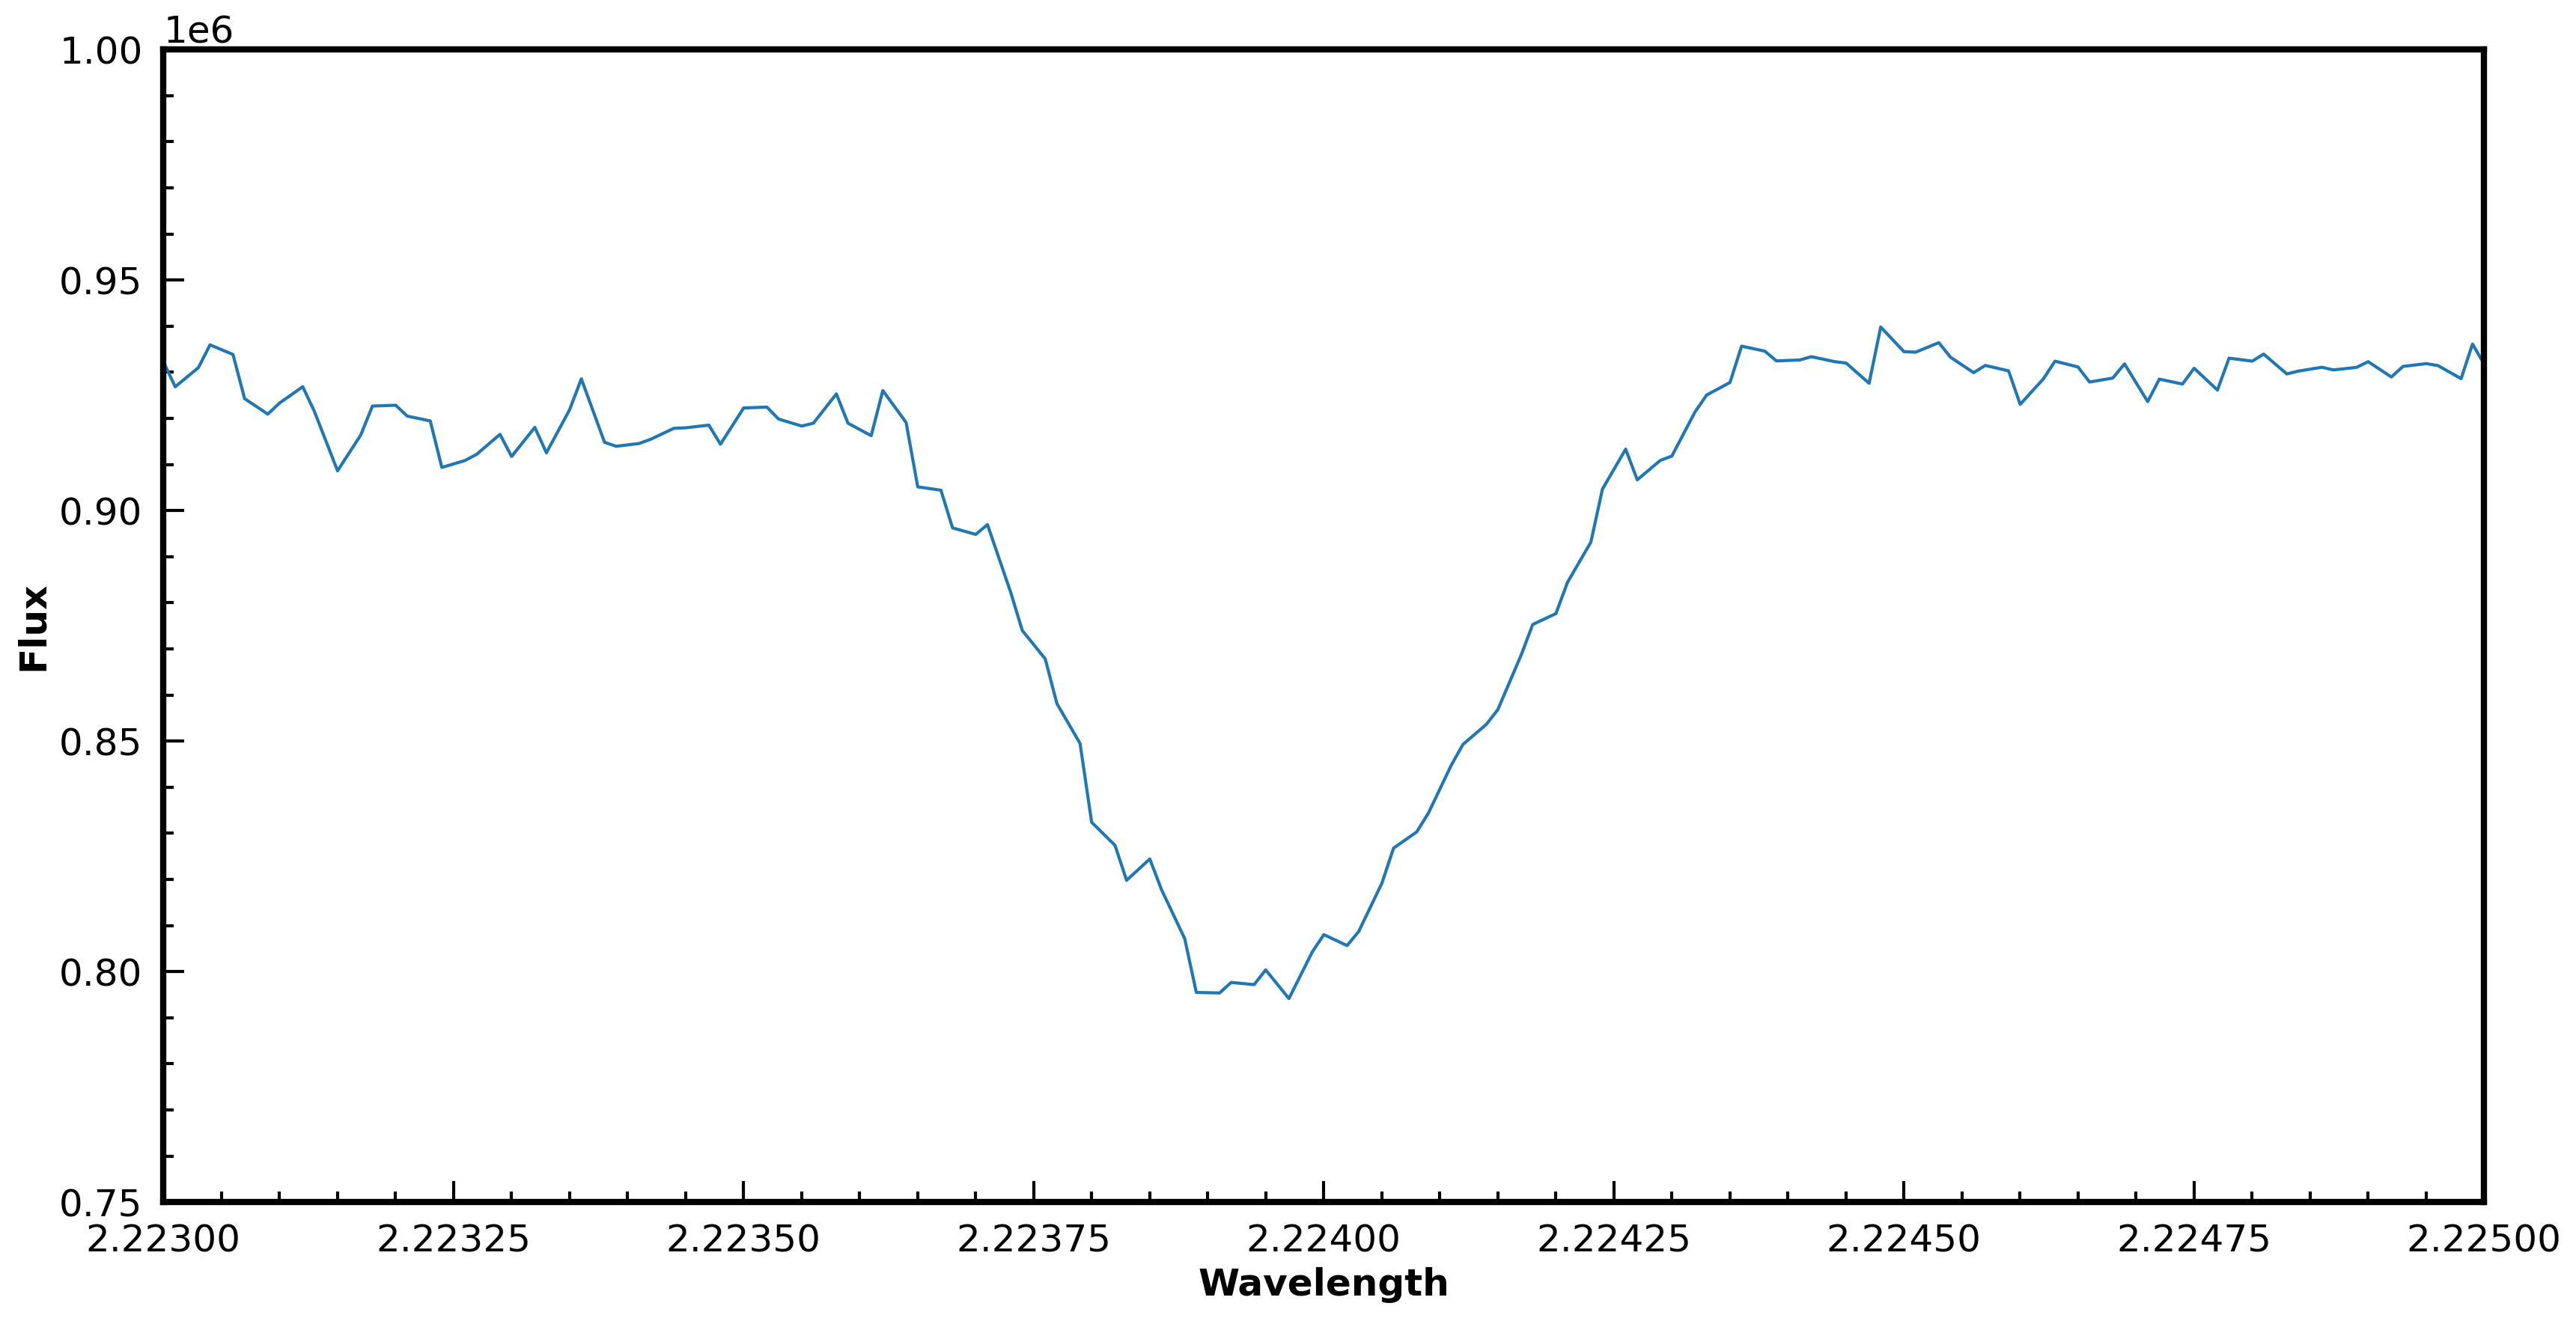

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(anon1_spec.spectral_axis, anon1_spec.flux)

ax.set_xlim(2.223,2.225)
ax.set_ylim(7.5e5,1e6)
# ax.set_yscale('log')
# ax.set_xscale('log')

# Enable minor tick marks
ax.minorticks_on()
ax.tick_params(axis='both', which='major', width=1.5, length=10, pad=10)
ax.tick_params(axis='both', which='minor', width=1.5, length=5, pad=10)

plt.xlabel('Wavelength')
plt.ylabel('Flux')
# ax.grid(which='both')
plt.show()

In [ ]:
# Define spectral regions we want to exclude from the continuum fit
reg1 = SpectralRegion(2.2215*u.micron,2.2223*u.micron)
reg2 = SpectralRegion(2.2235*u.micron,2.2243*u.micron)
reg3 = SpectralRegion(2.226*u.micron,2.2269*u.micron)
reg4 = SpectralRegion(2.2272*u.micron,2.2277*u.micron)

region = (2.22,2.235)*u.um
region_mask = (anon1_spec.spectral_axis >= region[0]) & (anon1_spec.spectral_axis <= region[1])


with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    cont_fit = fit_continuum(anon1_spec,window=(2.22,2.235)*u.um,exclude_regions=[reg1,reg2,reg3,reg4])


continuum_fitted = cont_fit(anon1_spec.spectral_axis)

anon1_norm_flux = anon1_spec.flux/continuum_fitted

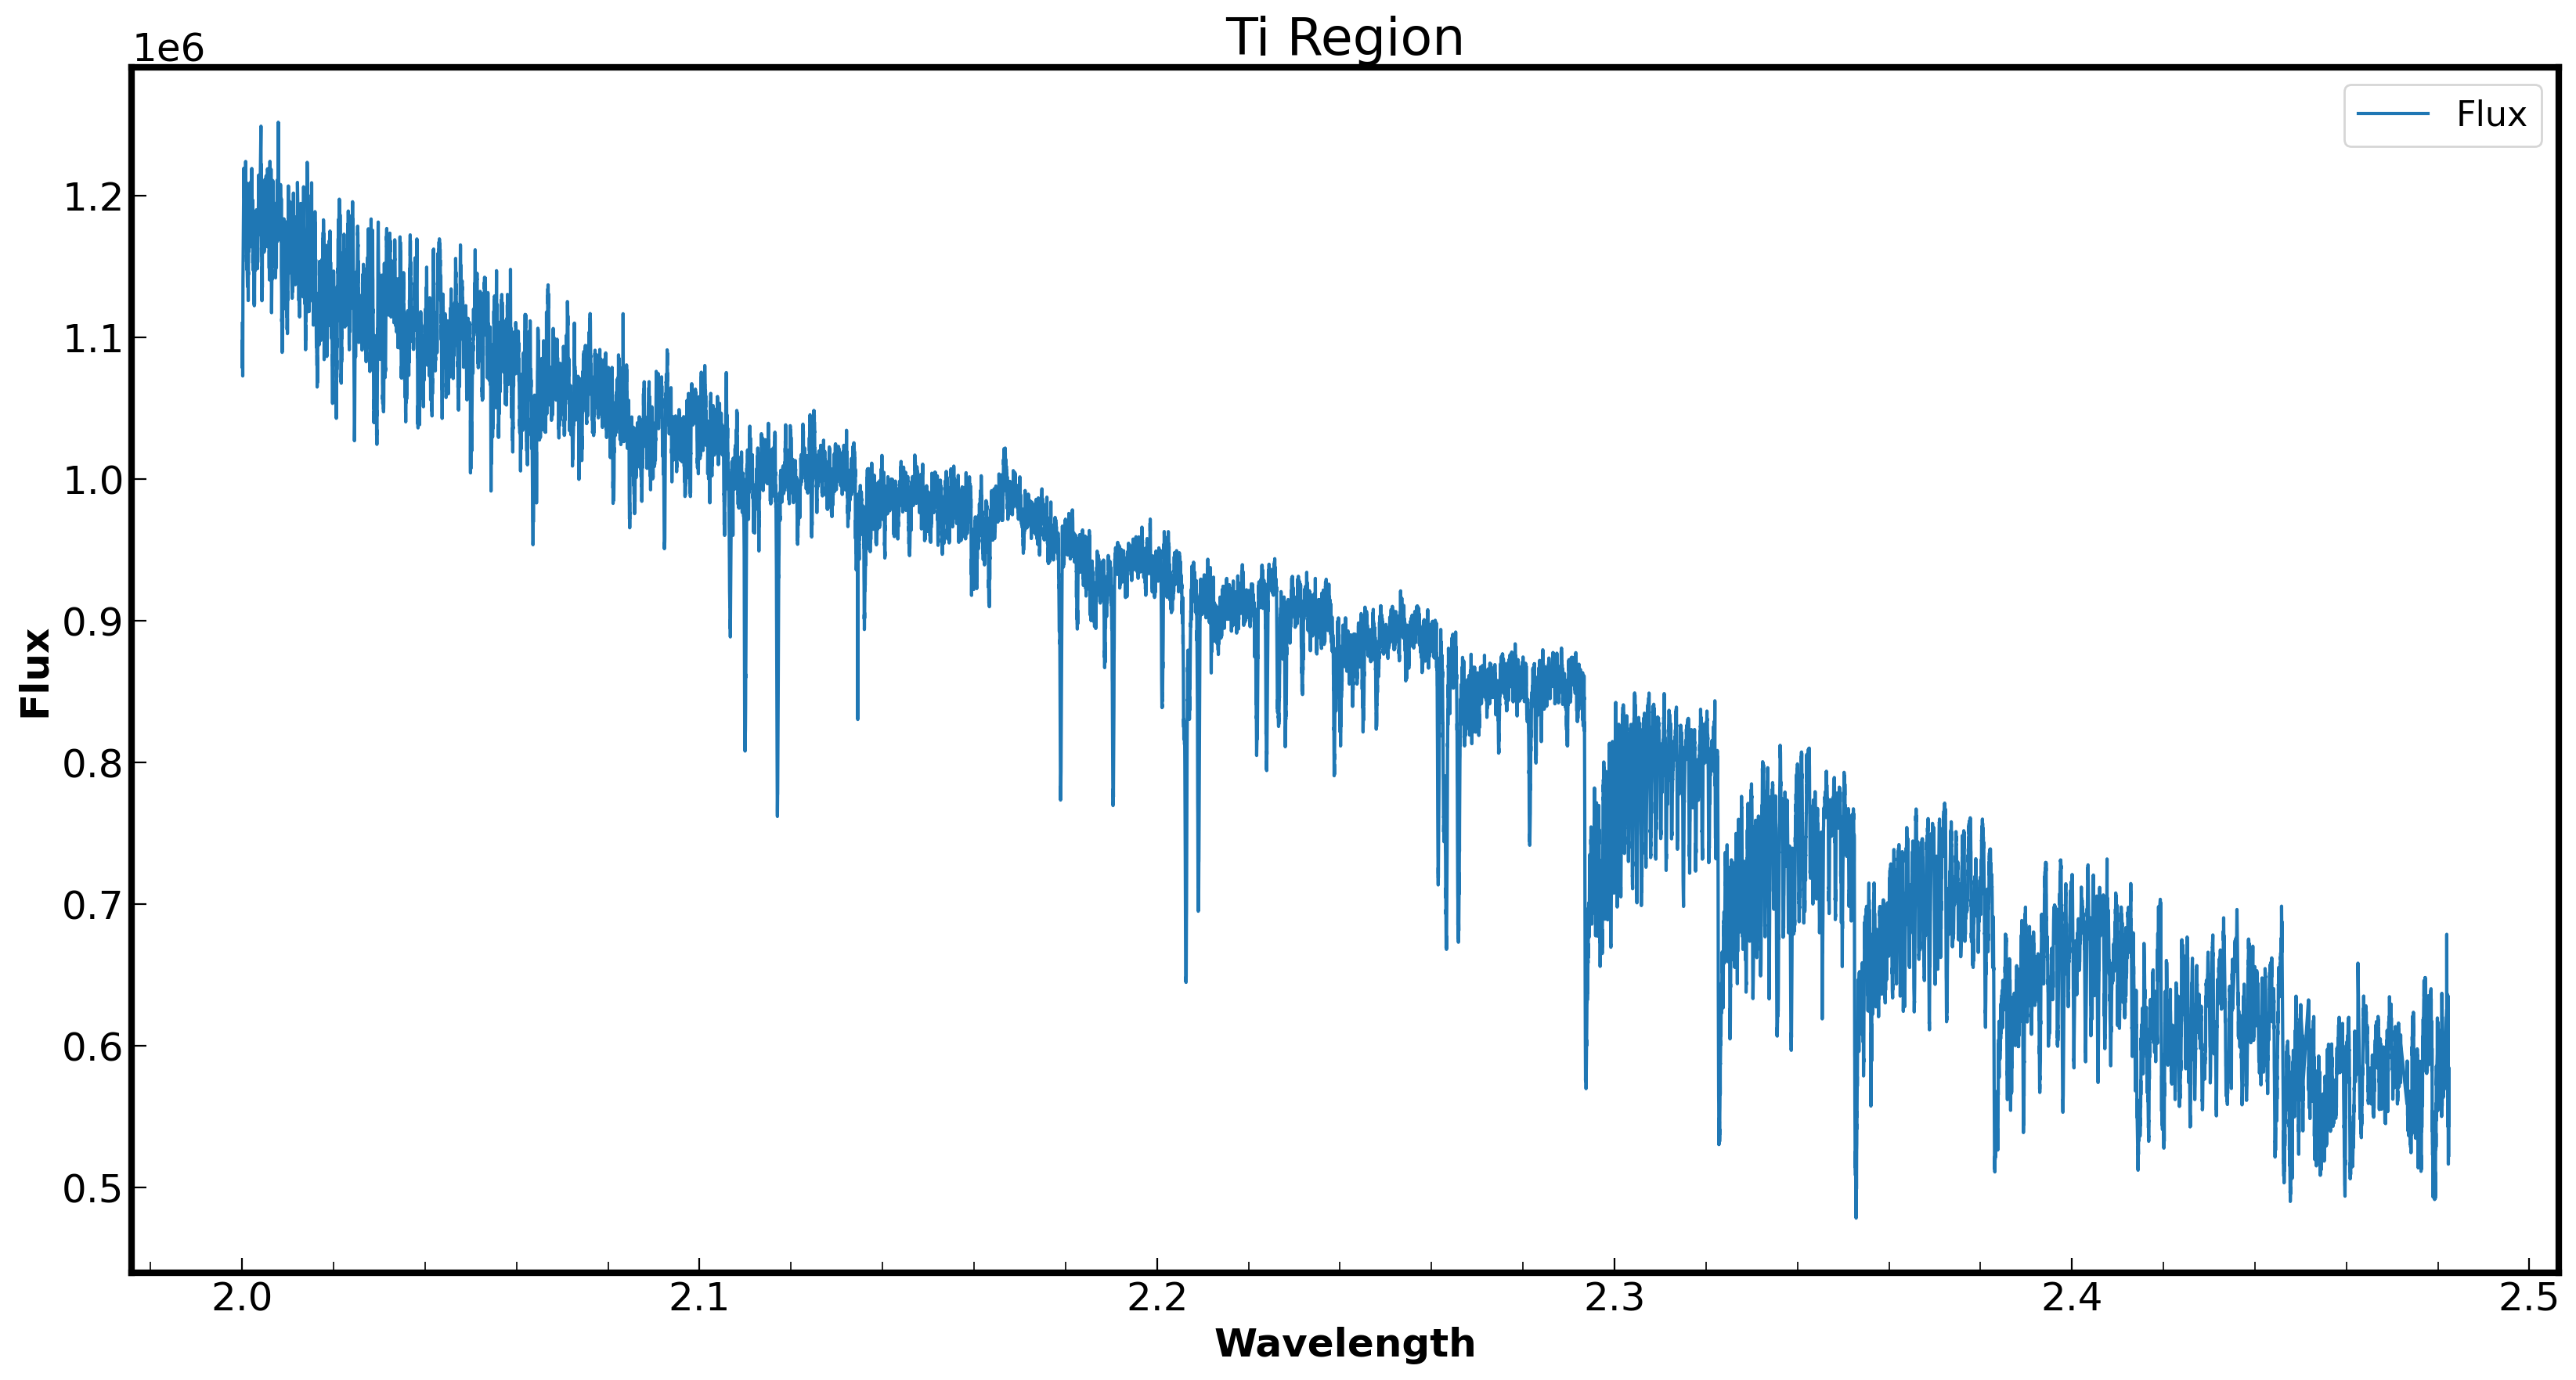

In [ ]:
# Make a plot
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(anon1_spec.spectral_axis, anon1_spec.flux,label='Flux')
# plt.plot(anon1_spec.spectral_axis, anon1_spec.flux/continuum_fitted,label='Continuum Normalized Flux')
# plt.plot(anon1_spec.spectral_axis,continuum_fitted,label='Continuum')

# ax.set_xlim(2.223,2.225)
# ax.set_ylim(7.5e5,1e6)

# ax.set_yscale('log')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Ti Region')
plt.legend()
plt.show()

In [ ]:
anon1_norm_spec = Spectrum1D(spectral_axis=anon1_spec.spectral_axis[region_mask], flux=anon1_norm_flux[region_mask]*u.ct)

In [ ]:
# Spectral Region
# sr = SpectralRegion(2.22*u.um,2.235*u.um)
sr = SpectralRegion(2.2216*u.um,2.2221*u.um)
# Equivalent Width
ew = equivalent_width(anon1_spec,regions=sr)
ew

<Quantity -422.68645245 um>

In [ ]:
continuum_fitted

<Quantity [1146896.54110953, 1146886.02072692, 1146875.39504921, ...,
            542990.62809961,  542976.27622738,  542961.92428619] ct>

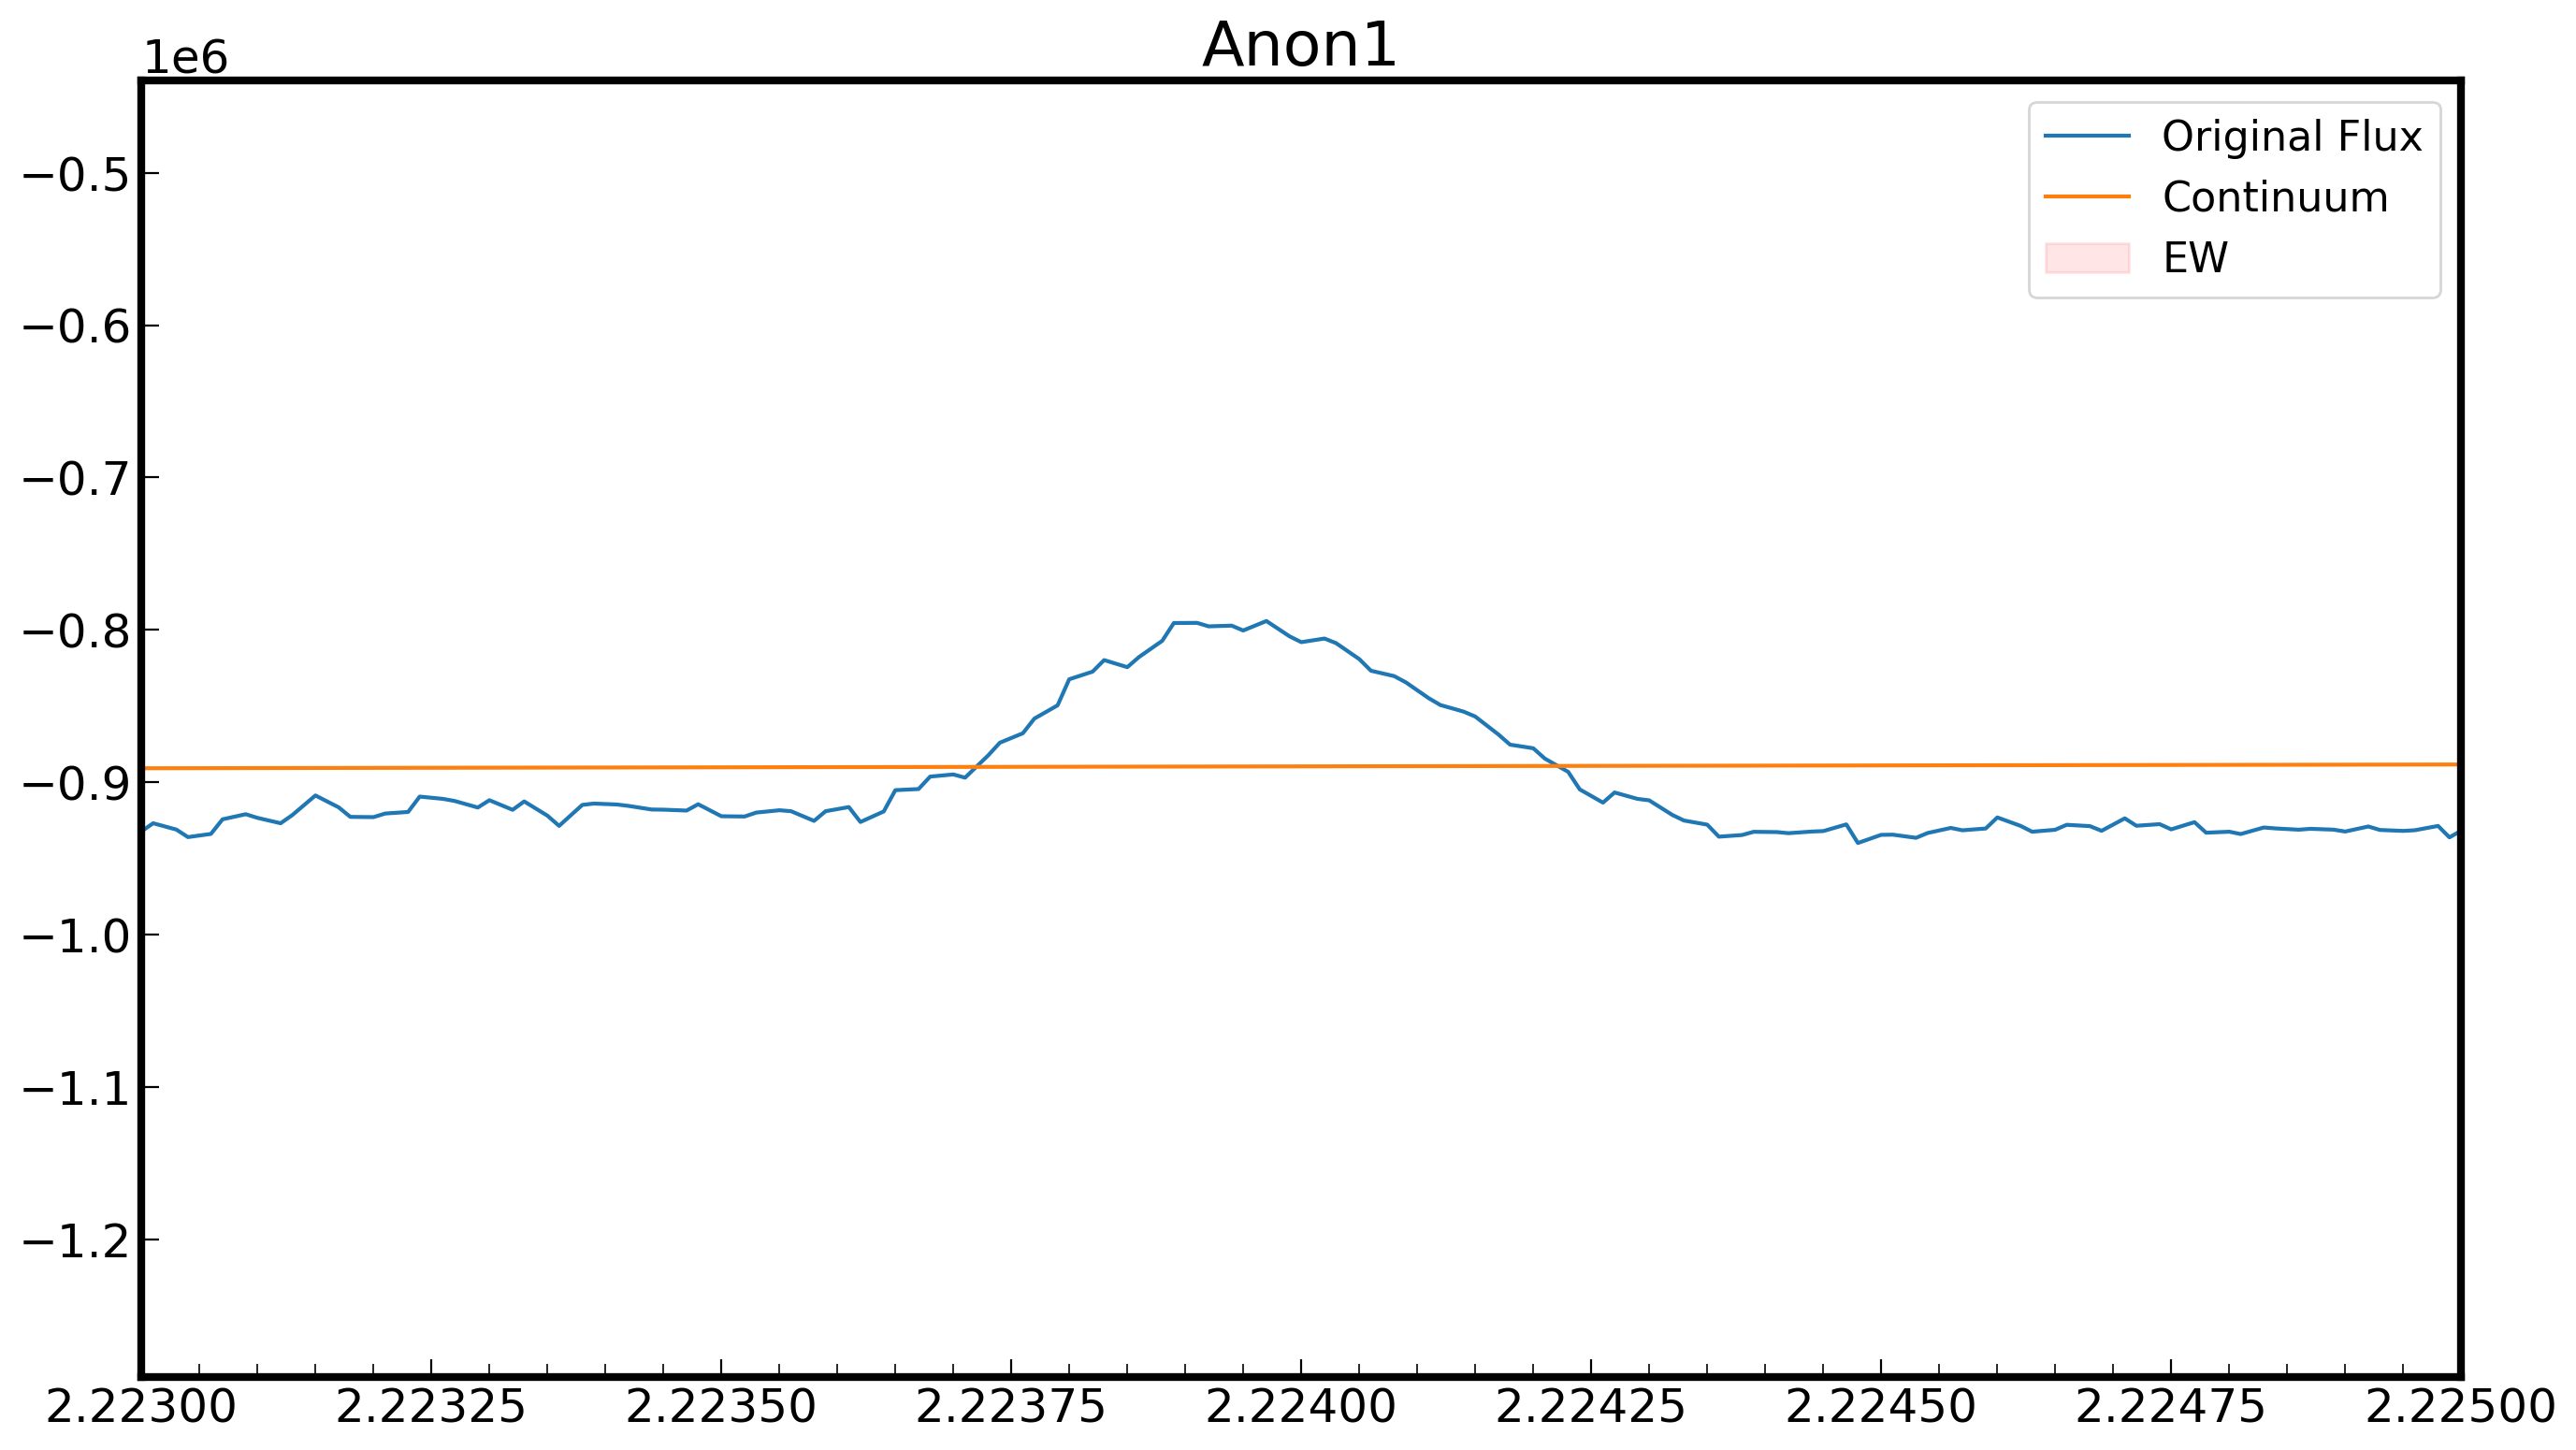

In [ ]:
anon1_norm_spec = Spectrum1D(spectral_axis=anon1_wavlen.values*u.um,flux=anon1_norm_flux)
norm_cont = continuum_fitted/continuum_fitted.max()*u.ct

fig,ax = plt.subplots(figsize=(16,9)) 

ax.plot(anon1_spec.spectral_axis,anon1_spec.flux*(-1),label='Original Flux')
# ax.plot(anon1_spec.spectral_axis[region_mask],anon1_norm_flux,label='Normalized Flux')
# ax.plot(anon1_norm_spec.spectral_axis,anon1_norm_spec.flux,label='Normalized Flux')
ax.plot(anon1_spec.spectral_axis[region_mask],continuum_fitted[region_mask]*(-1),label='Continuum')

# Draw the Equivalent Width box for my amusement
ax.axvspan(2.2216,2.2221,alpha=0.1,color='red',label='EW')

# plt.text(x_position, y_position, f"Equivalent Width: {eq_width.value:.2f} {eq_width.unit}", fontsize=12)
# ax.text(2.2216,2.2221,f"Equivalent Width: {ew.value:.2f}{ew.unit}")

ax.set_xlim(2.223,2.225)
# ax.set_ylim(0.8,1.1)
ax.set_title('Anon1')
plt.legend()

# Save plot as PNG
plt.savefig("A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/anon1_cont.png")
# Show the Plot
plt.show()

<!-- # Tom IDL Code
f1=f1+veil1[0]*median(f1[where(w1 ge 2.08 and w1 le 2.37)])

f2=f2+veil1[1]*median(f2[where(w2 ge 2.08 and w2 le 2.37)])

f3=f3+veil1[2]*median(f3[where(w3 ge 2.08 and w3 le 2.37)])

f4=f4+veil1[3]*median(f4[where(w4 ge 2.08 and w4 le 2.37)])

f5=f5+veil1[4]*median(f5[where(w5 ge 2.08 and w5 le 2.37)])

f6=f6+veil1[5]*median(f6[where(w6 ge 2.08 and w6 le 2.37)]) -->

In [ ]:
noise_region = SpectralRegion(0*u.um, 3*u.um)

spectrum = noise_region_uncertainty(anon1_spec, noise_region)


lines = find_lines_threshold(spectrum, noise_factor=3)  

lines[lines['line_type'] == 'emission']



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
um,,
float64,str8,int64
2.0079,emission,411
2.37217,emission,25118
2.38322,emission,25848
2.40767,emission,27298
2.4144101,emission,27736
2.41448,emission,27741
2.4193101,emission,28001
2.4458201,emission,29534
